In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
import optuna
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import learning_curve
# Load data
hh = pd.read_csv("households_complex.csv")

print(hh.head())
print(hh.info())


   household_id    governorate area_type  num_members  num_children  \
0             1          North     Urban           11             3   
1             2  Mount Lebanon     Urban            6             6   
2             3  Mount Lebanon       ITS            9             5   
3             4          Bekaa     Rural            7             2   
4             5          North     Urban            8             3   

   num_elderly  num_working_age  head_age head_gender   head_education  ...  \
0            2                6        61      Female              NaN  ...   
1            2                1        30        Male  Lower secondary  ...   
2            1                3        65        Male  Lower secondary  ...   
3            0                5        51        Male       University  ...   
4            0                5        52      Female          Primary  ...   

   assistance_last_6m  dependency_ratio  consumption_per_capita  rent_share  \
0                  

In [2]:
#sns.pairplot(hh,hue="vulnerability_flag")

<Axes: >

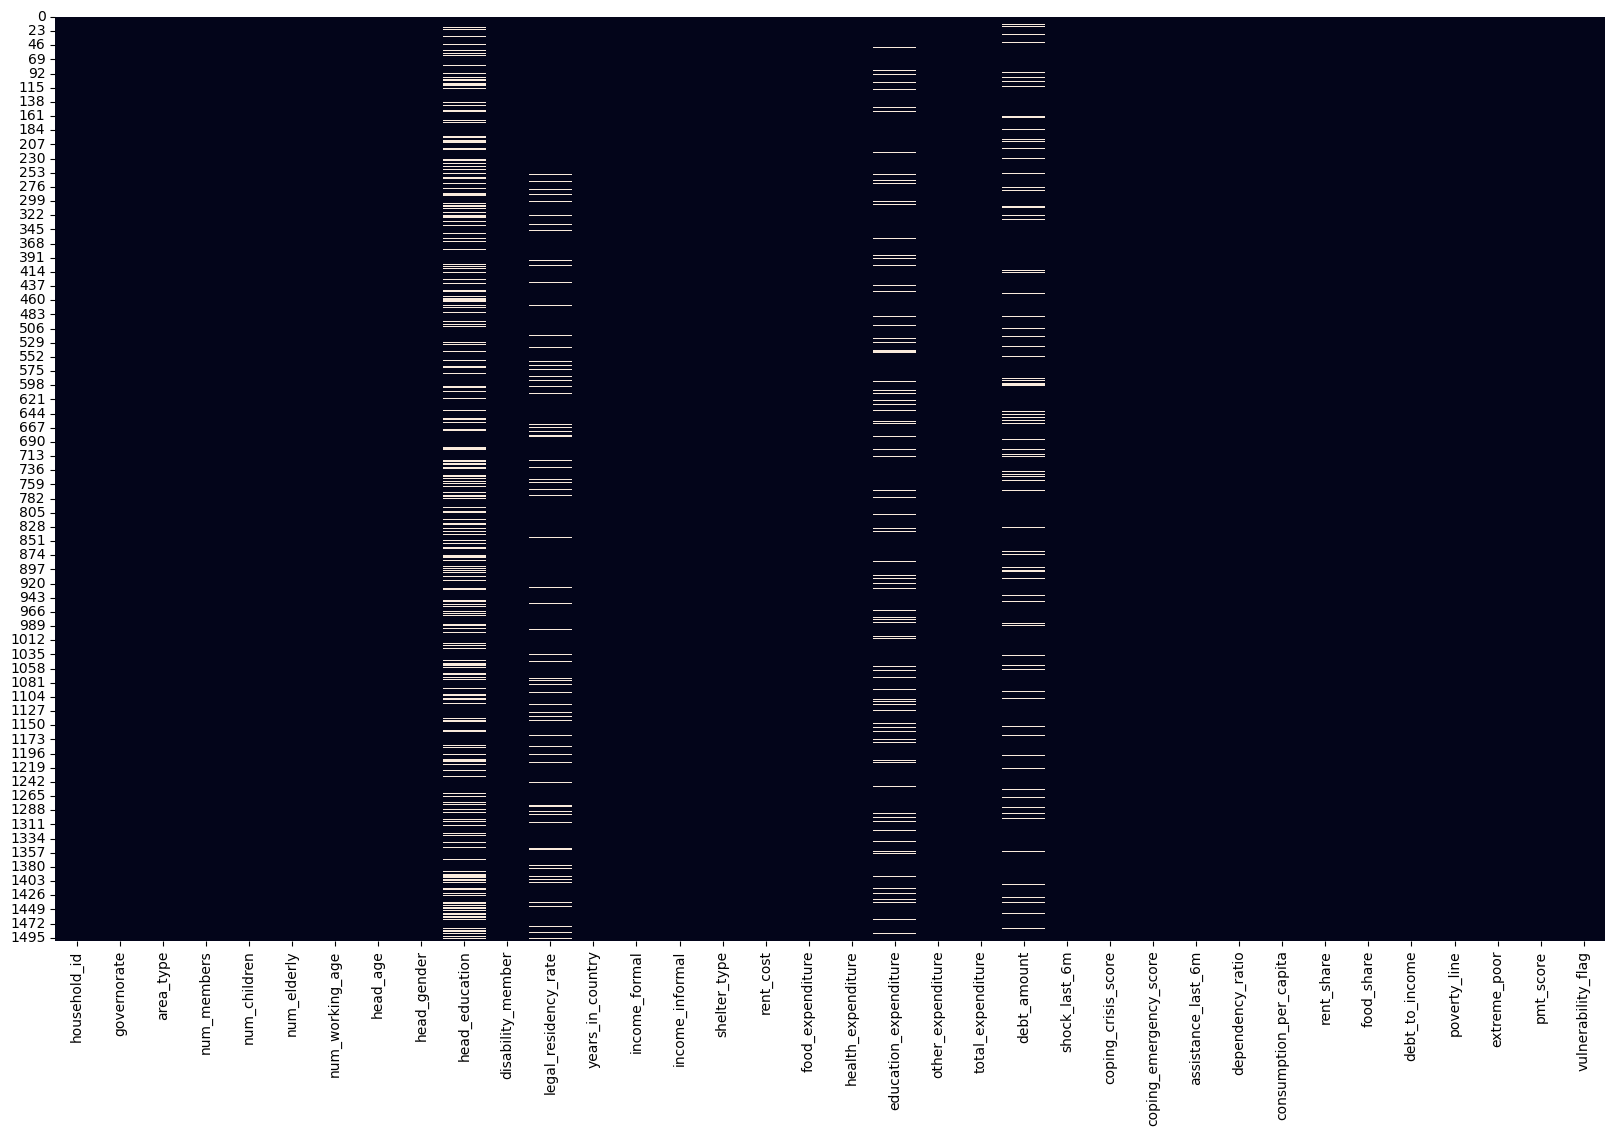

In [3]:
plt.figure(figsize=(20,12))
sns.heatmap(hh.isna(),cbar=False)

In [4]:
print(hh["head_education"].value_counts(normalize=True))

head_education
Primary            0.320536
Lower secondary    0.310714
Upper secondary    0.244643
University         0.124107
Name: proportion, dtype: float64


In [5]:
hh.dtypes

household_id                int64
governorate                object
area_type                  object
num_members                 int64
num_children                int64
num_elderly                 int64
num_working_age             int64
head_age                    int64
head_gender                object
head_education             object
disability_member           int64
legal_residency_rate      float64
years_in_country            int64
income_formal             float64
income_informal           float64
shelter_type               object
rent_cost                 float64
food_expenditure          float64
health_expenditure        float64
education_expenditure     float64
other_expenditure         float64
total_expenditure         float64
debt_amount               float64
shock_last_6m               int64
coping_crisis_score         int64
coping_emergency_score      int64
assistance_last_6m          int64
dependency_ratio          float64
consumption_per_capita    float64
rent_share    

In [6]:
toLabel=hh.select_dtypes(include="object").columns.tolist()
toLabel

['governorate', 'area_type', 'head_gender', 'head_education', 'shelter_type']

In [7]:
encoder=OrdinalEncoder()
hh[toLabel]=encoder.fit_transform(hh[toLabel])

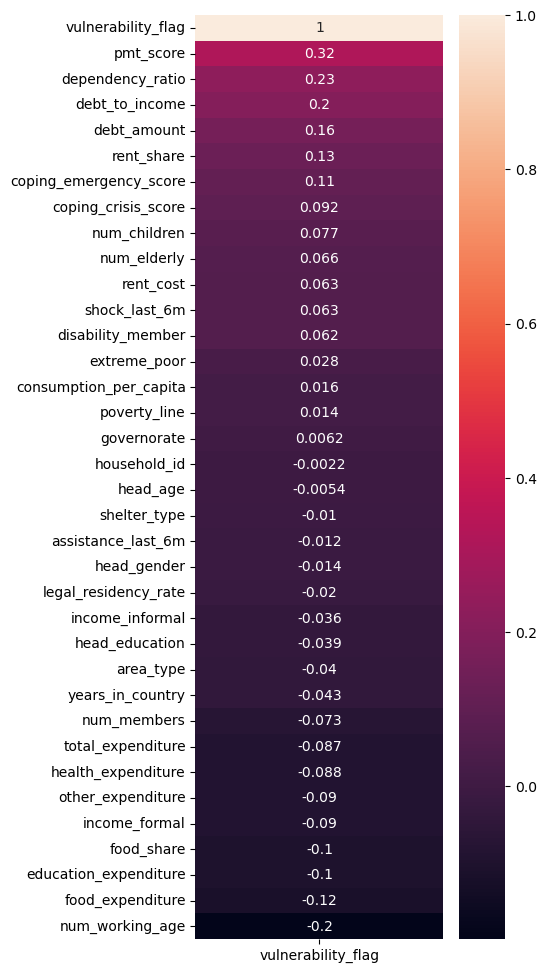

In [8]:
plt.figure(figsize=(4,12))
sns.heatmap(hh.corr(method="spearman")[["vulnerability_flag"]].sort_values(by="vulnerability_flag",ascending=False),cbar=True,annot=True)
plt.show()

In [9]:
print(hh.isna().sum())

household_id                0
governorate                 0
area_type                   0
num_members                 0
num_children                0
num_elderly                 0
num_working_age             0
head_age                    0
head_gender                 0
head_education            380
disability_member           0
legal_residency_rate      100
years_in_country            0
income_formal               0
income_informal             0
shelter_type                0
rent_cost                   0
food_expenditure            0
health_expenditure          0
education_expenditure     129
other_expenditure           0
total_expenditure           0
debt_amount               124
shock_last_6m               0
coping_crisis_score         0
coping_emergency_score      0
assistance_last_6m          0
dependency_ratio            0
consumption_per_capita      0
rent_share                  0
food_share                  0
debt_to_income              0
poverty_line                0
extreme_po

In [10]:
hh.describe()

,household_id,governorate,area_type,num_members,num_children,num_elderly,num_working_age,head_age,head_gender,head_education,...,assistance_last_6m,dependency_ratio,consumption_per_capita,rent_share,food_share,debt_to_income,poverty_line,extreme_poor,pmt_score,vulnerability_flag
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1120.000000,...,1500.000000,1500.000000,1.500000e+03,1500.000000,1500.000000,1500.000000,1.500000e+03,1500.000000,1500.000000,1500.000000
mean,750.500000,2.313333,1.341333,6.557333,2.942667,0.526667,3.168000,46.734000,0.701333,1.302679,...,0.482000,0.525237,1.570773e+06,0.365254,0.408191,0.999307,7.820333e+06,0.113333,0.447965,0.116000
std,433.157015,1.640208,0.786493,2.860565,1.802280,0.698771,1.781168,15.963034,0.457826,1.150200,...,0.499843,0.244923,1.178191e+06,0.175880,0.092627,1.302749,7.678626e+05,0.317106,0.119583,0.320332
min,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,...,0.000000,0.000000,2.830000e+05,0.023000,0.116000,0.030000,7.000000e+06,0.000000,0.000000,0.000000
25%,375.750000,1.000000,1.000000,4.000000,2.000000,0.000000,2.000000,33.000000,0.000000,0.000000,...,0.000000,0.375000,7.910000e+05,0.223750,0.351000,0.310000,7.000000e+06,0.000000,0.370300,0.000000
50%,750.500000,2.000000,2.000000,7.000000,3.000000,0.000000,3.000000,47.000000,1.000000,1.000000,...,0.000000,0.500000,1.172000e+06,0.360000,0.409000,0.600000,7.500000e+06,0.000000,0.447600,0.000000
75%,1125.250000,4.000000,2.000000,9.000000,4.000000,1.000000,4.000000,61.000000,1.000000,2.000000,...,1.000000,0.666667,1.933000e+06,0.507000,0.475000,1.220000,8.500000e+06,0.000000,0.524225,0.000000
max,1500.000000,5.000000,2.000000,11.000000,10.000000,3.000000,10.000000,74.000000,1.000000,3.000000,...,1.000000,1.500000,1.000000e+07,0.852000,0.600000,18.670000,9.000000e+06,1.000000,1.000000,1.000000


vulnerability_flag
0    0.884
1    0.116
Name: proportion, dtype: float64

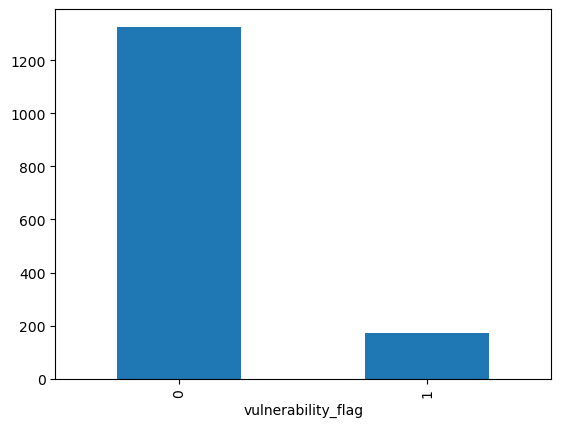

In [11]:
hh["vulnerability_flag"].value_counts().plot.bar()
hh["vulnerability_flag"].value_counts(normalize=True)

In [12]:
hh.drop(columns=["education_expenditure","head_education"],inplace=True)


In [13]:
hh["debt_amount"]=hh["debt_amount"].fillna(0.0)
hh["legal_residency_rate"]=hh["legal_residency_rate"].fillna(hh["legal_residency_rate"].median())

<Axes: >

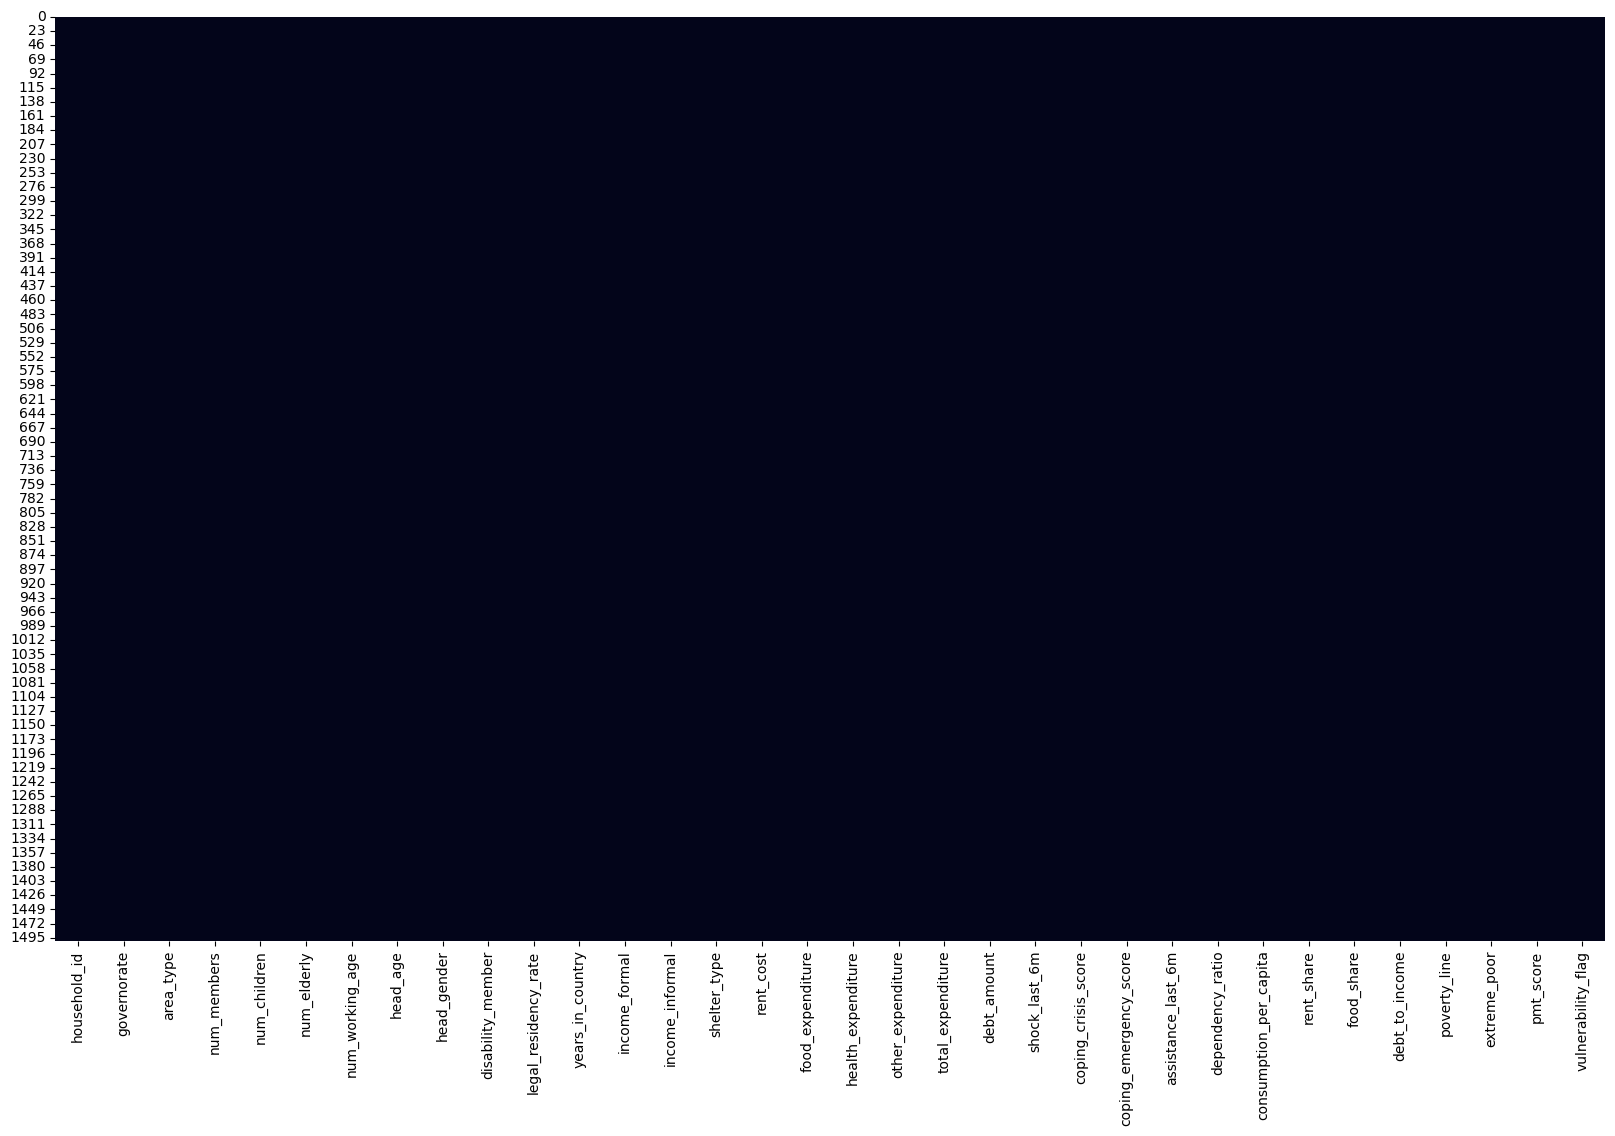

In [14]:
plt.figure(figsize=(20,12))
sns.heatmap(hh.isna(),cbar=False)

In [15]:
xcolumns=[c for c in hh.columns if c not in ["vulnerability_flag","household_id","pmt_score"]]
X=hh[xcolumns]
y=hh["vulnerability_flag"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

In [16]:
def objective(trial):
    k = trial.suggest_int("k", 5, X.shape[1])
    # 2. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest', 'LogisticRegression'])
    if classifier_name == 'SVC':
         svc_c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
         classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')
    elif classifier_name=='LogisticRegression':
        C = trial.suggest_float('C', 1e-5, 1e2, log=True)    
        penalty =  trial.suggest_categorical('penalty',['l1', 'l2'])
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga']) 
        classifier_obj = sklearn.linear_model.LogisticRegression(C=C,penalty=penalty,solver=solver)
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    model=Pipeline([
        ("Select",SelectKBest(f_classif,k=k)),
        ("clf",classifier_obj)])

    skf = StratifiedKFold(n_splits=5)    
    accuracy= cross_val_score(model,X,y,cv=skf).mean()
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-12-01 21:06:17,161] A new study created in memory with name: no-name-3012a367-06b4-40a6-92fe-f4eb37200070
[I 2025-12-01 21:06:17,356] Trial 0 finished with value: 0.8906666666666666 and parameters: {'k': 15, 'classifier': 'RandomForest', 'rf_max_depth': 4}. Best is trial 0 with value: 0.8906666666666666.
[I 2025-12-01 21:06:18,050] Trial 1 finished with value: 0.8846666666666667 and parameters: {'k': 26, 'classifier': 'LogisticRegression', 'C': 0.0016296009125722148, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8906666666666666.
[I 2025-12-01 21:06:18,157] Trial 2 finished with value: 0.8826666666666666 and parameters: {'k': 7, 'classifier': 'LogisticRegression', 'C': 56.23601247317256, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8906666666666666.
[I 2025-12-01 21:06:18,391] Trial 3 finished with value: 0.884 and parameters: {'k': 23, 'classifier': 'SVC', 'svc_c': 5.811654353715284e-10}. Best is trial 0 with value: 0.89066666

In [17]:
best_params = study.best_params
print(best_params)

{'k': 9, 'classifier': 'RandomForest', 'rf_max_depth': 8}


In [18]:
final_model = Pipeline([
    ("select", SelectKBest(f_classif, k=10)),
    ("clf", RandomForestClassifier(max_depth=8))
])

final_model.fit(X, y)
pred=final_model.predict(X_test)
accuracy_score(y_test, pred)



0.952

In [22]:
from sklearn.linear_model import LogisticRegression

# 1. Create the model
model = LogisticRegression()

# 2. Fit the model
model.fit(X_train, y_train)

# 3. Predict
y_pred = model.predict(X_test)

# 4. Accuracy (optional)
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8933333333333333


C:\Users\batoul.fneish\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


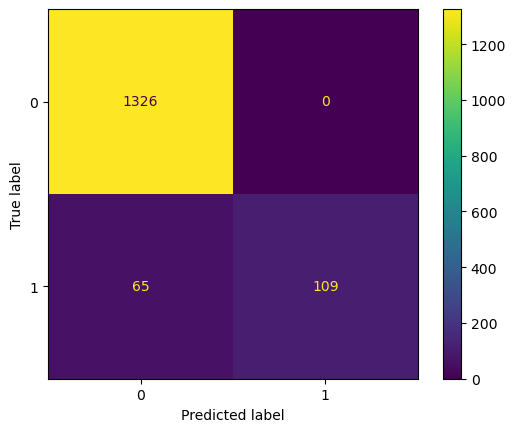

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(final_model, X, y)
plt.show()

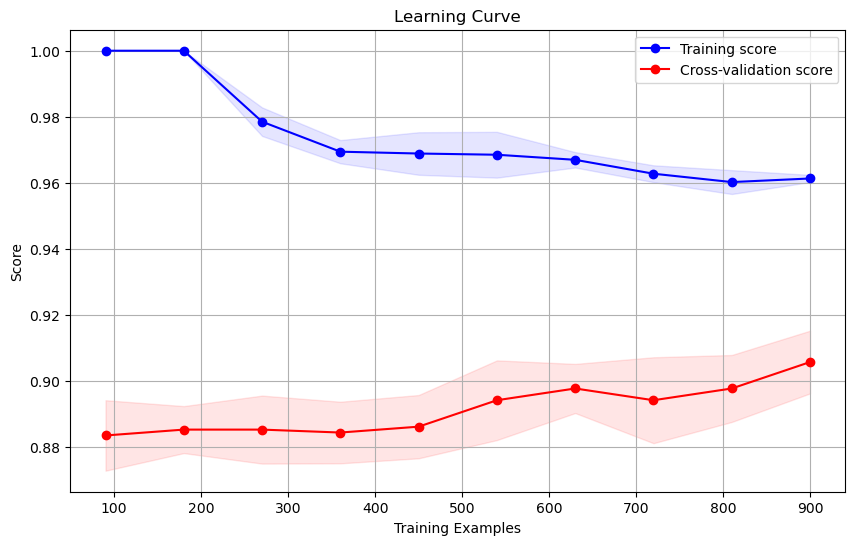

In [26]:
train_sizes, train_scores, test_scores = learning_curve(
        final_model, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10) # Varying training set sizes
    )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)




plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="red", marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="red")

plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

C:\Users\batoul.fneish\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


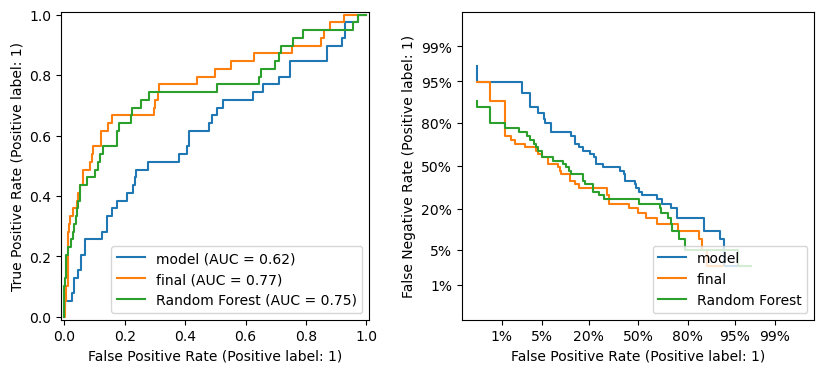

In [33]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import DetCurveDisplay
classifiers = {
    "model": model,
    "final": final_model,
    "Random Forest": RandomForestClassifier(max_depth=5, random_state=42)
}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(10, 4))
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

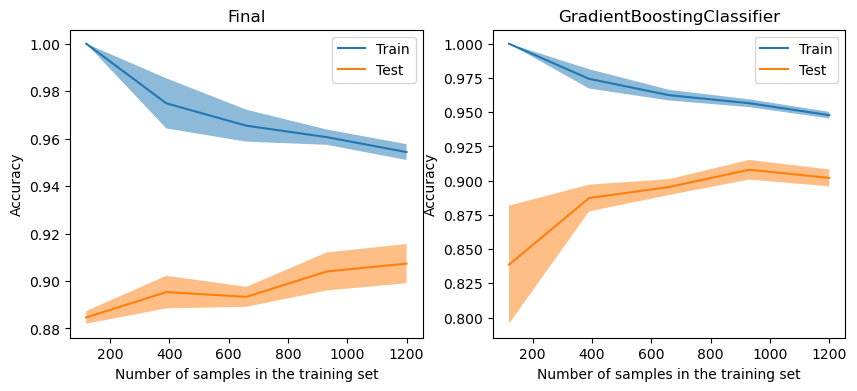

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import LearningCurveDisplay



tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, max_depth=3, tol=1e-3)

train_sizes = np.linspace(0.4, 1.0, 10)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
LearningCurveDisplay.from_estimator(final_model, X, y,
                                
                                    ax=axes[0],
                                    scoring='accuracy')
axes[0].set_title('Final')
LearningCurveDisplay.from_estimator(gb_clf, X, y,
                                  
                                    ax=axes[1],
                                    scoring='accuracy')
axes[1].set_title('GradientBoostingClassifier')
plt.show()